# Content Agnostic GCN

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

import torch
from torch_geometric.data import Data, HeteroData
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.nn import GCNConv

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.model_selection import train_test_split

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear
from torch_geometric.nn.inits import glorot, zeros

## 01 Load Data
https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html

In [4]:
#edge_list = pd.read_csv('../02_data/content_agnostic/train_edge_list.csv') 

In [5]:
# Validated Projected Monopartite Network
edge_np = np.load("../02_data/content_agnostic/validated_edges.npy", allow_pickle=True)
edge_nodes = set(edge_np.flatten()) 

# Convert edge list numpy array to DataFrame
edge_list = pd.DataFrame(edge_np, columns=["source", "target"])

In [6]:
edge_list

,source,target
0,6059,6063
1,6059,6095
2,6059,6102
3,6059,6139
4,6059,6142
...,...,...
464685,2219,6377
464686,2219,6461
464687,2219,6491
464688,2219,6529


In [7]:
chat_data = pd.read_csv('grouped_main_topics.csv')

In [8]:
train_data = pd.read_csv('../02_data/content_agnostic/train_data.csv')
test_data = pd.read_csv('../02_data/content_agnostic/test_data.csv')

In [9]:
print("edge_list info (train edges)")
print(edge_list.info())
print("-------------------------------------------------")

print("chat_data info")
print(chat_data.info())
print("-------------------------------------------------")

print("train_data info")
print(train_data.info())
print("-------------------------------------------------")

print("test_data info")
print(test_data.info())
print("-------------------------------------------------")

edge_list info (train edges)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464690 entries, 0 to 464689
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   source  464690 non-null  int64
 1   target  464690 non-null  int64
dtypes: int64(2)
memory usage: 7.1 MB
None
-------------------------------------------------
chat_data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49412 entries, 0 to 49411
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 49412 non-null  int64  
 1   name               49412 non-null  object 
 2   type               49412 non-null  object 
 3   db_index           49412 non-null  int64  
 4   description        49411 non-null  object 
 5   message_count      49412 non-null  float64
 6   total_view_count   49412 non-null  float64
 7   total_fwd_count    49412 non-null  float64
 8   oldest_post    

In [10]:
print(chat_data['topic'].max())
print(chat_data['topic'].min())

18
-1


## 02 Preprocessing

In [11]:
# edge_list only contains valid domain indices
valid_domain_indices = set(train_data['domain_id'])

edge_list_filtered = edge_list[
    edge_list['source'].isin(valid_domain_indices) & edge_list['target'].isin(valid_domain_indices)
]

# mapping from original domain indices to new contiguous indices
unique_nodes = sorted(valid_domain_indices)  
node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(unique_nodes)}

# Apply re-indexing to edge_list
edge_index_mapped = edge_list_filtered.replace(node_mapping).values
edge_index = torch.tensor(edge_index_mapped, dtype=torch.long).t().contiguous()

# Update node_features to match new indices
train_data = train_data[train_data['domain_id'].isin(valid_domain_indices)]
train_data = train_data.set_index('domain_id').reindex(unique_nodes).fillna(0)
chat_data = chat_data.set_index('db_index')

In [12]:
train_data.describe()

,virality,avalanches,messages,chats,year,pc1
count,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000
mean,0.881850,3.233327,5.882586,2.035745,2021.561378,0.588963
std,0.106087,12.925501,42.946197,4.110890,1.014816,0.202186
min,0.136170,1.000000,1.000000,1.000000,2016.000000,0.017644
25%,0.842707,1.263158,1.426477,1.125000,2021.200000,0.480598
50%,0.898030,1.868132,2.218638,1.477064,2021.753247,0.624068
75%,0.951128,2.669253,3.459008,2.000000,2022.155343,0.722048
max,1.000000,643.000000,2106.500000,196.666667,2023.000000,1.000000


In [13]:
# node features
train_features = train_data[['virality', 'avalanches', 'messages', 'chats', 'year']].fillna(0)
train_features = (train_features - train_features.mean()) / train_features.std()

train_features.describe()

,virality,avalanches,messages,chats,year
count,5.915000e+03,5.915000e+03,5.915000e+03,5.915000e+03,5.915000e+03
mean,1.073322e-15,-1.261318e-17,6.606906e-18,1.201256e-18,3.784616e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.028965e+00,-1.727845e-01,-1.136908e-01,-2.519516e-01,-5.480185e+00
25%,-3.689695e-01,-1.524249e-01,-1.037603e-01,-2.215446e-01,-3.561019e-01
50%,1.525231e-01,-1.056202e-01,-8.531485e-02,-1.359027e-01,1.890678e-01
75%,6.530304e-01,-4.364037e-02,-5.643291e-02,-8.695276e-03,5.852938e-01
max,1.113714e+00,4.949647e+01,4.891277e+01,4.734521e+01,1.417619e+00


In [14]:
# Align indices and merge features
node_features = train_features.reindex(train_data.index).fillna(0)
node_features = torch.tensor(node_features.values, dtype=torch.float)

In [15]:
# Target labels
pc1_values = train_data['pc1']
labels = pd.cut(pc1_values, bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=[0, 1, 2])
#train_data["pc1_class"] = np.digitize(train_data["pc1"], bins=[0.33, 0.66])
labels = torch.tensor(labels.values, dtype=torch.long)

In [16]:
# Train-test split
train_mask, val_mask = train_test_split(np.arange(len(labels)), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
val_mask = torch.tensor(val_mask, dtype=torch.long)

## 03 Model

In [96]:
# Define GCN Model
class GCN_super_basic(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0):
        super(GCN_super_basic, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [95]:
class GCN_basic(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0):
        super(GCN_basic, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [20]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super(GAT, self).__init__()
        
        # First GAT layer (multi-head attention)
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        
        # Second GAT layer
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        
        # Output GAT layer (single head for classification)
        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Exponential Linear Unit (ELU) for better convergence
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)  # Classification output


In [21]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super(GraphSAGE, self).__init__()

        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)  

https://medium.com/stanford-cs224w/incorporating-edge-features-into-graph-neural-networks-for-country-gdp-predictions-1d4dea68337d

In [22]:
class GATEdgeAttr(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super(GATEdgeAttr, self).__init__()
        
        # multi-head attention
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout, edge_dim=1)
        
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout, edge_dim=1)
        
        # single head for classification
        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout)

        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)  # Exponential Linear Unit 
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index, edge_attr=edge_attr)
        return F.log_softmax(x, dim=1)  # Classification output


## 04 Training

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [78]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=labels.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [136]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

def train_model(model_class, in_channels, hidden_channels, out_channels, 
                node_features, edge_index, labels, train_mask, val_mask, 
                device, num_epochs=100, lr=0.005, weight_decay=1e-4, edge_attr=None):

    model = model_class(in_channels, hidden_channels, out_channels).to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()  #weight=class_weights

    # Move data to device
    node_features, edge_index = node_features.to(device), edge_index.to(device)
    labels, train_mask, val_mask = labels.to(device), train_mask.to(device), val_mask.to(device)

    train_losses, val_losses = [], []
    start_time = time.time()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass 
        out = model(node_features, edge_index)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(node_features, edge_index)
            val_loss = criterion(val_out[val_mask], labels[val_mask])

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    training_time = time.time() - start_time
    print(f"Model: {model_class.__name__}")
    print(f"Training Time: {training_time:.2f}s")

    # Plot Learning Curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.show()

    return model, train_losses, val_losses


Epoch 0, Train Loss: 1.0763, Val Loss: 1.0297
Epoch 10, Train Loss: 0.9722, Val Loss: 0.9673
Epoch 20, Train Loss: 0.9519, Val Loss: 0.9391
Epoch 30, Train Loss: 0.9466, Val Loss: 0.9367
Epoch 40, Train Loss: 0.9422, Val Loss: 0.9299
Epoch 50, Train Loss: 0.9382, Val Loss: 0.9253
Epoch 60, Train Loss: 0.9346, Val Loss: 0.9210
Epoch 70, Train Loss: 0.9312, Val Loss: 0.9167
Epoch 80, Train Loss: 0.9282, Val Loss: 0.9125
Epoch 90, Train Loss: 0.9256, Val Loss: 0.9093
Model: GCN_super_basic
Training Time: 0.49s


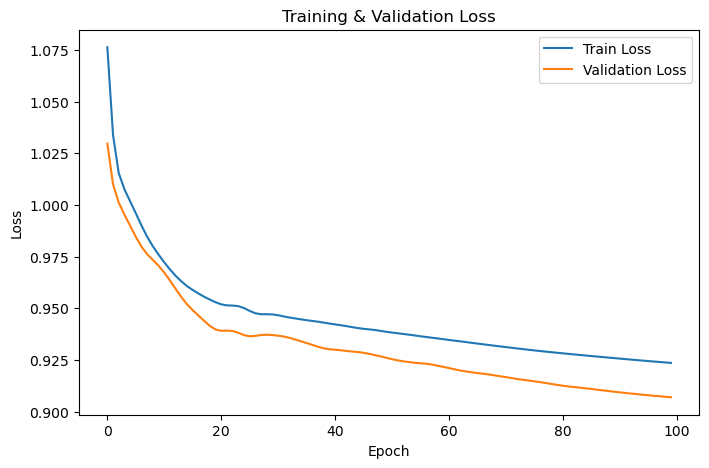

In [137]:
best_gcn_sb_model, train_losses, val_losses = train_model(
    model_class=GCN_super_basic,  
    in_channels=node_features.shape[1],
    hidden_channels=128,
    out_channels=3,
    node_features=node_features,
    edge_index=edge_index,
    labels=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    device=device,
    num_epochs=100,
    lr=0.01,
    weight_decay=1e-4,
    edge_attr=None
)

Epoch 0, Train Loss: 1.0949, Val Loss: 1.0926
Epoch 10, Train Loss: 0.9685, Val Loss: 0.9578
Epoch 20, Train Loss: 0.9409, Val Loss: 0.9306
Epoch 30, Train Loss: 0.9316, Val Loss: 0.9215
Epoch 40, Train Loss: 0.9239, Val Loss: 0.9140
Epoch 50, Train Loss: 0.9156, Val Loss: 0.9048
Epoch 60, Train Loss: 0.9070, Val Loss: 0.8955
Epoch 70, Train Loss: 0.8986, Val Loss: 0.8904
Epoch 80, Train Loss: 0.8900, Val Loss: 0.8869
Epoch 90, Train Loss: 0.8863, Val Loss: 0.8806
Model: GCN_basic
Training Time: 0.76s


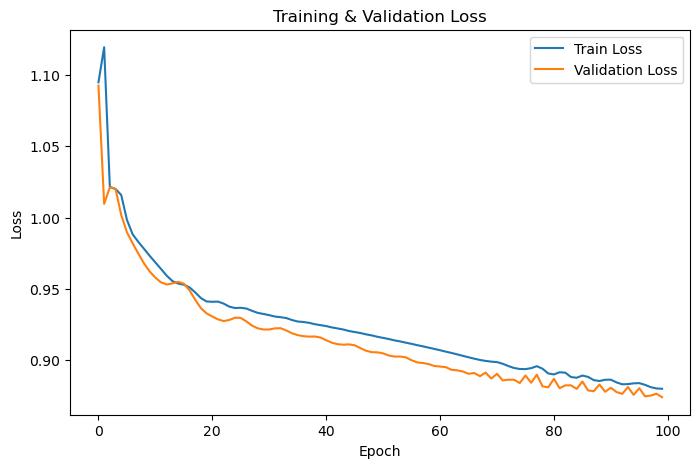

In [138]:
best_gcn_b_model, train_losses, val_losses = train_model(
    model_class=GCN_basic,  
    in_channels=node_features.shape[1],
    hidden_channels=128,
    out_channels=3,
    node_features=node_features,
    edge_index=edge_index,
    labels=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    device=device,
    num_epochs=100,
    lr=0.01,
    weight_decay=1e-4,
    edge_attr=None
)

Epoch 0, Train Loss: 1.1113, Val Loss: 1.0574
Epoch 10, Train Loss: 0.9630, Val Loss: 0.9469
Epoch 20, Train Loss: 0.9402, Val Loss: 0.9269
Epoch 30, Train Loss: 0.9314, Val Loss: 0.9181
Epoch 40, Train Loss: 0.9227, Val Loss: 0.9083
Epoch 50, Train Loss: 0.9186, Val Loss: 0.9000
Epoch 60, Train Loss: 0.9096, Val Loss: 0.8911
Epoch 70, Train Loss: 0.9044, Val Loss: 0.8885
Epoch 80, Train Loss: 0.9024, Val Loss: 0.8980
Epoch 90, Train Loss: 0.8992, Val Loss: 0.8835
Model: GCN
Training Time: 0.77s


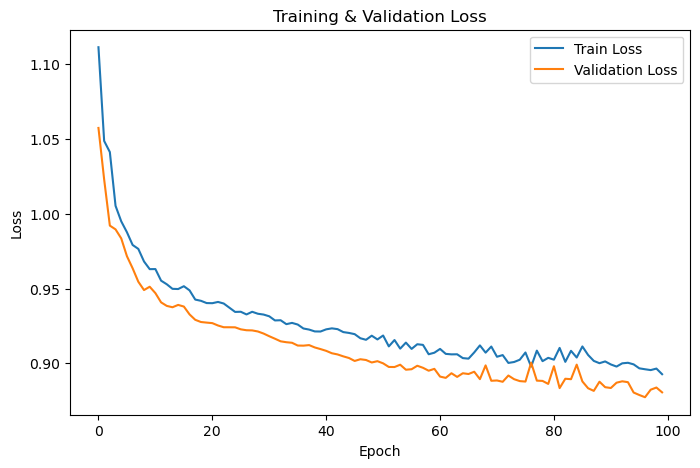

In [139]:
best_gcn_model, train_losses, val_losses = train_model(
    model_class=GCN,  
    in_channels=node_features.shape[1],
    hidden_channels=128,
    out_channels=3,
    node_features=node_features,
    edge_index=edge_index,
    labels=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    device=device,
    num_epochs=100,
    lr=0.01,
    weight_decay=1e-4,
    edge_attr=None
)

Epoch 0, Train Loss: 1.1139, Val Loss: 1.2202
Epoch 10, Train Loss: 1.0228, Val Loss: 1.0151
Epoch 20, Train Loss: 0.9921, Val Loss: 0.9854
Epoch 30, Train Loss: 0.9712, Val Loss: 0.9504
Epoch 40, Train Loss: 0.9557, Val Loss: 0.9438
Epoch 50, Train Loss: 0.9518, Val Loss: 0.9400
Epoch 60, Train Loss: 0.9442, Val Loss: 0.9554
Epoch 70, Train Loss: 0.9401, Val Loss: 0.9362
Epoch 80, Train Loss: 0.9447, Val Loss: 0.9414
Epoch 90, Train Loss: 0.9347, Val Loss: 0.9384
Model: GAT
Training Time: 1.61s


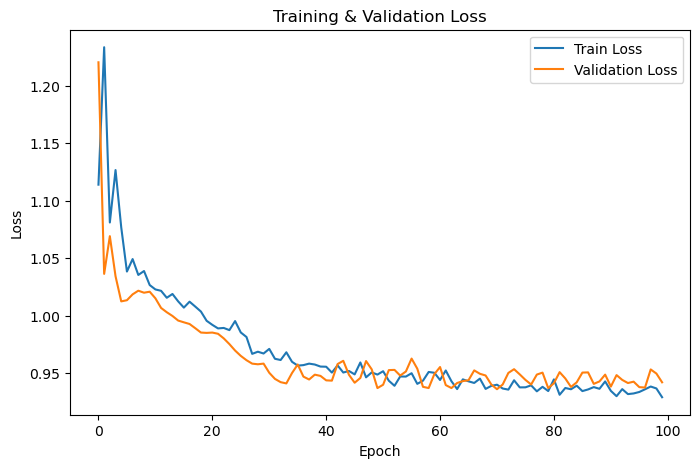

In [140]:
best_gat_model, train_losses, val_losses = train_model(
    model_class=GAT,  
    in_channels=node_features.shape[1],
    hidden_channels=64,
    out_channels=3,
    node_features=node_features,
    edge_index=edge_index,
    labels=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    device=device,
    num_epochs=100,
    lr=0.01,
    weight_decay=1e-5,
    edge_attr=None
)

Epoch 0, Train Loss: 1.1490, Val Loss: 1.0171
Epoch 10, Train Loss: 0.9642, Val Loss: 0.9511
Epoch 20, Train Loss: 0.9369, Val Loss: 0.9207
Epoch 30, Train Loss: 0.9221, Val Loss: 0.9050
Epoch 40, Train Loss: 0.9107, Val Loss: 0.9008
Epoch 50, Train Loss: 0.9035, Val Loss: 0.8935
Epoch 60, Train Loss: 0.8988, Val Loss: 0.8946
Epoch 70, Train Loss: 0.8957, Val Loss: 0.8913
Epoch 80, Train Loss: 0.8951, Val Loss: 0.8933
Epoch 90, Train Loss: 0.8930, Val Loss: 0.8890
Epoch 100, Train Loss: 0.8901, Val Loss: 0.8878
Epoch 110, Train Loss: 0.8903, Val Loss: 0.8846
Epoch 120, Train Loss: 0.8902, Val Loss: 0.8844
Epoch 130, Train Loss: 0.8799, Val Loss: 0.8857
Epoch 140, Train Loss: 0.8881, Val Loss: 0.8866
Epoch 150, Train Loss: 0.8842, Val Loss: 0.8858
Epoch 160, Train Loss: 0.8793, Val Loss: 0.8824
Epoch 170, Train Loss: 0.8819, Val Loss: 0.8886
Epoch 180, Train Loss: 0.8752, Val Loss: 0.8804
Epoch 190, Train Loss: 0.8783, Val Loss: 0.8835
Model: GraphSAGE
Training Time: 0.71s


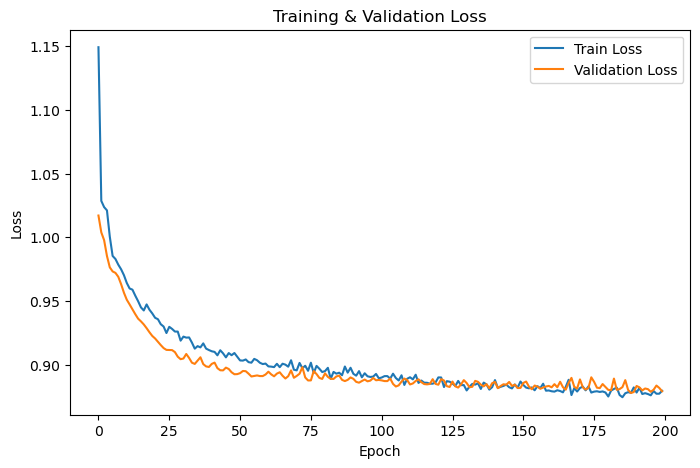

In [141]:
best_sage_model, train_losses, val_losses = train_model(
    model_class=GraphSAGE,  
    in_channels=node_features.shape[1],
    hidden_channels=64,
    out_channels=3,
    node_features=node_features,
    edge_index=edge_index,
    labels=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    device=device,
    num_epochs=200,
    lr=0.01,
    weight_decay=1e-3,
    edge_attr=None
)

In [142]:
'''
model_SAGEatttr, train_losses, val_losses = train_model(
    model_class=GraphSAGEWithEdgeAttr,  
    in_channels=node_features.shape[1],
    hidden_channels=128,
    out_channels=3,
    node_features=node_features,
    edge_index=edge_index,
    labels=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    device=device,
    num_epochs=100,
    lr=0.005,
    weight_decay=1e-4,
    edge_attr=edge_attr
)
'''

'\nmodel_SAGEatttr, train_losses, val_losses = train_model(\n    model_class=GraphSAGEWithEdgeAttr,  \n    in_channels=node_features.shape[1],\n    hidden_channels=128,\n    out_channels=3,\n    node_features=node_features,\n    edge_index=edge_index,\n    labels=labels,\n    train_mask=train_mask,\n    val_mask=val_mask,\n    device=device,\n    num_epochs=100,\n    lr=0.005,\n    weight_decay=1e-4,\n    edge_attr=edge_attr\n)\n'

## 05 Hyperparameter Tuning

In [143]:
from sklearn.model_selection import ParameterGrid
from torch.optim import Adam

param_grid = {
    "hidden_size": [32, 64, 128],
    "dropout": [0, 0.3, 0.5],
    "learning_rate": [0.01, 0.005, 0.001],
    "weight_decay": [1e-5, 1e-4, 1e-3]
}

# Get all parameter combinations
grid = list(ParameterGrid(param_grid))

In [144]:
def train_and_tune_model(model_class, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr=None):
    best_model = None
    best_params = None
    best_val_loss = float("inf")

    node_features = node_features.to(device)
    edge_index = edge_index.to(device)
    labels = labels.to(device)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)

    if edge_attr is not None:
        edge_attr = edge_attr.to(device)
            
    # Loop through all hyperparameter combinations
    for params in grid:
        # print(f"Training with params: {params}")

        # Initialize the model with dynamic parameters
        model = model_class(
            in_channels=node_features.shape[1], 
            hidden_channels=params["hidden_size"], 
            out_channels=3, 
            dropout=params["dropout"]
        ).to(device)

        optimizer = Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
        criterion = torch.nn.CrossEntropyLoss() #weight=class_weights

        num_epochs = 100
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            if edge_attr is not None:
                out = model(node_features, edge_index, edge_attr)
            else:
                out = model(node_features, edge_index)
            loss = criterion(out[train_mask], labels[train_mask])
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            if edge_attr is not None:
                val_out = model(node_features, edge_index, edge_attr)
            else:
                val_out = model(node_features, edge_index)
            val_loss = criterion(val_out[val_mask], labels[val_mask]).item()

        # print(f"Validation Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = params

    print("Best Hyperparameters:", best_params)
    print("Best Validation Loss:", best_val_loss)

    # Save best model
    #torch.save(best_model.state_dict(), "best_gnn_model.pth")
    #print("💾 Best model saved as 'best_gnn_model.pth'")

    return best_model, best_params, best_val_loss

In [145]:
best_gcn_sb_model, best_gcn_params, best_gcn_val_loss = train_and_tune_model(
    GCN_super_basic, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr=None
)

Best Hyperparameters: {'dropout': 0.3, 'hidden_size': 128, 'learning_rate': 0.01, 'weight_decay': 1e-05}
Best Validation Loss: 0.9044067859649658


In [146]:
best_gcn_b_model, best_gcn_params, best_gcn_val_loss = train_and_tune_model(
    GCN_basic, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr=None
)

Best Hyperparameters: {'dropout': 0, 'hidden_size': 128, 'learning_rate': 0.01, 'weight_decay': 1e-05}
Best Validation Loss: 0.8692246079444885


In [147]:
best_gcn_model, best_gcn_params, best_gcn_val_loss = train_and_tune_model(
    GCN, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr=None
)

Best Hyperparameters: {'dropout': 0, 'hidden_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Best Validation Loss: 0.8746063709259033


In [148]:
best_gat_model, best_gat_params, best_gat_val_loss = train_and_tune_model(
    GAT, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr=None
)

Best Hyperparameters: {'dropout': 0, 'hidden_size': 64, 'learning_rate': 0.005, 'weight_decay': 1e-05}
Best Validation Loss: 0.8809814453125


In [149]:
best_sage_model, best_sage_params, best_sage_val_loss = train_and_tune_model(
    GraphSAGE, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr=None
)

Best Hyperparameters: {'dropout': 0.3, 'hidden_size': 64, 'learning_rate': 0.01, 'weight_decay': 1e-05}
Best Validation Loss: 0.8776968121528625


best_gat_attr_model, best_gat_attr_params, best_gat_attr_val_loss = train_and_tune_model(
    GATEdgeAttr, param_grid, node_features, edge_index, labels, train_mask, val_mask, device, class_weights, edge_attr
)

## 06 Evaluation

In [150]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

def evaluate_models(models, node_features, edge_index, labels, val_mask, device):
    results = []

    node_features, edge_index = node_features.to(device), edge_index.to(device)
    labels, val_mask = labels.to(device), val_mask.to(device)

    for model_name, model in models.items():
        model.eval()
        with torch.no_grad():
            #if model == best_gat_attr_model or model == model_SAGEatttr:
                #out = model(node_features, edge_index, edge_attr)
            #else:
            out = model(node_features, edge_index)
            pred = out.argmax(dim=1)

        # Convert tensors to numpy for metric calculations
        y_true = labels[val_mask].cpu().numpy()
        y_pred = pred[val_mask].cpu().numpy()

        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")

        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(conf_matrix) #, display_labels=["Class 0", "Class 1", "Class 2"]
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

        # Store results
        results.append({"Model": model_name, "Accuracy": accuracy, "F1-Score": f1})

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results)
    results_df.to_csv('../02_data/content_agnostic/results_df.csv', index=False)
    
    return results_df


Model: Super basic GCN
Accuracy: 0.5368
F1-Score: 0.5211

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.16      0.24       179
           1       0.49      0.68      0.57       510
           2       0.64      0.53      0.58       494

    accuracy                           0.54      1183
   macro avg       0.53      0.46      0.46      1183
weighted avg       0.55      0.54      0.52      1183



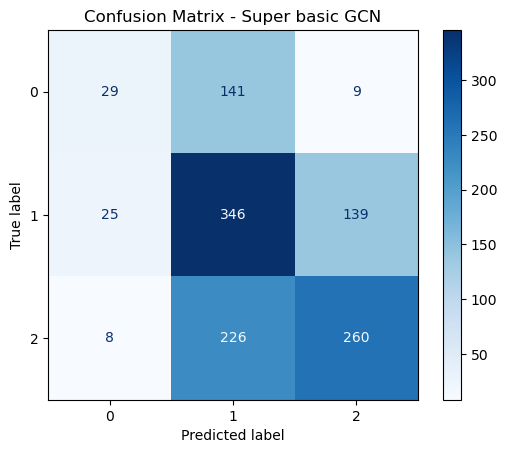

Model: Basic GCN
Accuracy: 0.5402
F1-Score: 0.5353

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.27      0.35       179
           1       0.48      0.63      0.55       510
           2       0.65      0.55      0.59       494

    accuracy                           0.54      1183
   macro avg       0.53      0.48      0.49      1183
weighted avg       0.55      0.54      0.54      1183



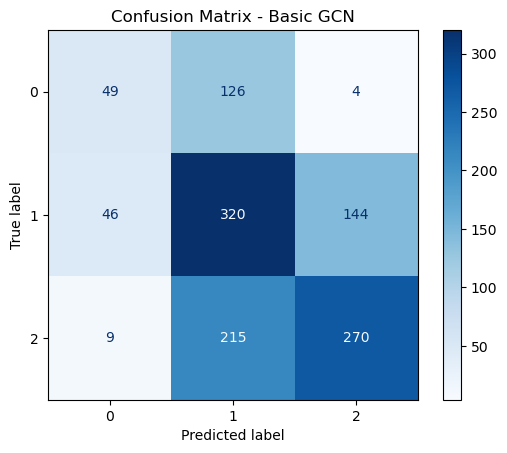

Model: GCN
Accuracy: 0.5418
F1-Score: 0.5340

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.23      0.31       179
           1       0.48      0.63      0.55       510
           2       0.64      0.57      0.60       494

    accuracy                           0.54      1183
   macro avg       0.53      0.47      0.49      1183
weighted avg       0.55      0.54      0.53      1183



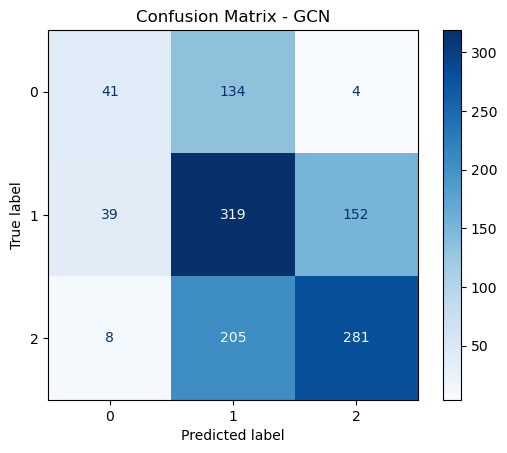

Model: GAT
Accuracy: 0.5393
F1-Score: 0.5312

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.25      0.33       179
           1       0.49      0.57      0.53       510
           2       0.60      0.62      0.61       494

    accuracy                           0.54      1183
   macro avg       0.54      0.48      0.49      1183
weighted avg       0.54      0.54      0.53      1183



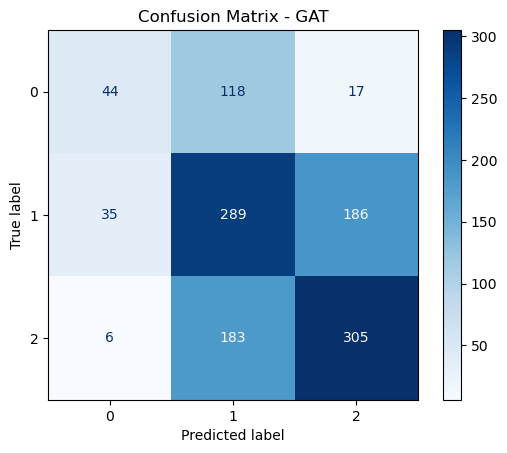

Model: GraphSAGE
Accuracy: 0.5596
F1-Score: 0.5472

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.20      0.28       179
           1       0.51      0.59      0.55       510
           2       0.63      0.66      0.64       494

    accuracy                           0.56      1183
   macro avg       0.54      0.48      0.49      1183
weighted avg       0.56      0.56      0.55      1183



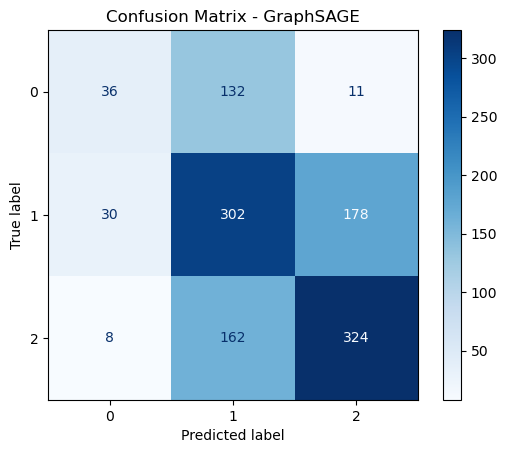

In [151]:
# Define models to evaluate
models_to_compare = {
    "Super basic GCN": best_gcn_sb_model,
    "Basic GCN": best_gcn_b_model,
    "GCN": best_gcn_model,
    "GAT": best_gat_model,
    "GraphSAGE": best_sage_model,
    #"GAT with edge attributes": best_gat_attr_model,
    #"GraphSAGE with edge attributes": model_SAGEatttr
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run evaluation on all models
evaluation_results = evaluate_models(
    models=models_to_compare, 
    node_features=node_features, 
    edge_index=edge_index, 
    labels=labels, 
    val_mask=val_mask, 
    device=device
)
